## Ejercicio - Regresión Viviendas Barcelona

- Utilizando el dataset de publicaciones de venta de viviendas en Barcelona _**viviendas_barcelona.parquet**_, entrena un modelo de regresión lineal múltiple que sea capaz de calcular el precio de venta:

    - Antes de crear el modelo y entrenarlo, haz un **EDA** de los datos.
        - ¿Qué columnas pueden ser las más importantes?
        - ¿Como se distribuyen los precios?
        - ¿Qué columnas sería factible limpiar?
        - ¿Qué significan los **np.nan**?
     
    - Cuando entiendas bien los datos con los que estás tratando, puedes proceder a realizar un preprocesamiento:
        - Elimina duplicados.
        - Elimina columnas innecesarias
        - Trata los valores perdidos **np.nan**.
        - Maneja los outliers como consideres.
        - Realiza transformaciones a los datos que consideres necesarias.
        - Codifica los datos categóricos para que el modelo los entienda (pásalos a números).
        - Considera normalizar los datos antes de utilizarlos para el entreno.
        
    - Entrena el modelo con un subconjunto de 70-80% del dataset.
      
    - Utiliza los datos restantes para comprobar cómo de bueno es el modelo:
        - Calcula **R2**, **MAE** y **MSE**.
        
- Importa las librerías que vayas a necesitar.

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelo
from sklearn.linear_model import LinearRegression

# Herramientas de preprocesamiento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, TargetEncoder, OneHotEncoder

# Split
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# pip install pyarrow
df = pd.read_parquet("../Data/viviendas_barcelona.parquet")

In [141]:
df.drop(['id_1', 'id_2', 'updated', 'timestamp', 'province', 'location', 'Referencia', 'Consumo', 'Se aceptan mascotas'], axis=1, inplace=True)

In [142]:
print(df.head())

      price                                              title        lat  \
0   52000.0            Piso en venta en Avenida Casetes, nº 33  41.348350   
1  315000.0    Casa adosada en venta en Vilafranca del Penedes  41.276503   
2  650000.0  Casa unifamiliar en venta en Sant Sadurní d'Anoia  41.426682   
3  315000.0       Casa en venta en Carrer de Sant Pere Molanta  41.318658   
4  209900.0  Chalet en venta en Calle Carrer Serral Llarg, ...  41.369700   

        lng                                  agency Superficie construida  \
0  1.701970       Inmuebles de Aliseda Inmobiliaria                 88 m²   
1  1.652229  Inmuebles de Engel & Völkers Barcelona                179 m²   
2  1.792630               Inmuebles de SAFTI ESPAÑA                253 m²   
3  1.754891        Inmuebles de ALARCON PROPIEDADES                198 m²   
4  1.876770              Inmuebles de FINCAS MARINA                494 m²   

                           Emisiones             Clasificación Baños  \
0 

In [143]:
# Superficie '1.250 m2' --> 1250
def extraer_superficie_num(superficie):
    try:
        return int(superficie.split()[0].replace('.',''))
    except:
        return np.nan

df['Superficie construida'] = df['Superficie construida'].apply(extraer_superficie_num)
median = df['Superficie construida'].median()
df['Superficie construida'] = df['Superficie construida'].fillna(median).round(0).astype(int)

In [144]:
# Convertir a numérico la columna Superficie útil y rellenar sus nulos
df['Superficie útil'] = df['Superficie útil'].apply(extraer_superficie_num)

def fill_superficie_util(fila):
    if pd.isnull(fila['Superficie útil']):
        return fila['Superficie construida'] * 0.85 # Asumimos que la superficie útil es un 15 % menos que la superficie total
    else:
        return fila['Superficie útil']

df['Superficie útil'] = df.apply(fill_superficie_util, axis=1)

In [145]:
# Emisiones (se podría eliminar si sabemos que no afecta a precio en la realidad)
def extraer_emisiones_num(emision):
    try:
        return float(emision.strip().split()[0].replace(',','.'))
    except:
        return np.nan

df['Emisiones'] = df['Emisiones'].apply(extraer_emisiones_num)
median = df['Emisiones'].median()
df['Emisiones'] = df['Emisiones'].fillna(median).round(2).astype(float)

In [146]:
# Estrategia 1: crer una columna agency_size que represente en número de propiedades en venta para esa agency
# Estrategia 2: crear una columna el percentil de tamaño de agencia en base al número de propiedades en venta
# Estrategia 3: discretizarla en grupos: propietario individual, agencia pequeña, agencia mediana, agencia grande
# Estrategia 4: precio medio de las casas de la agencia

# pd.set_option('display.max_rows', None)
# print(df['agency'].value_counts())
# df['agency'].isna().sum()
df['agency'] = df['agency'].fillna('Other') # Rellena los nulos con la palabra 'Other' o 0
df['agency_size'] = df['agency'].map(df['agency'].value_counts()) # Estrategia 1

In [147]:
pd.reset_option('display.max_rows')
df[['agency', 'agency_size']]

,agency,agency_size
0,Inmuebles de Aliseda Inmobiliaria,493
1,Inmuebles de Engel & Völkers Barcelona,2187
2,Inmuebles de SAFTI ESPAÑA,95
3,Inmuebles de ALARCON PROPIEDADES,30
4,Inmuebles de FINCAS MARINA,31
...,...,...
27474,Inmuebles de Engel & Völkers Barcelona,2187
27475,Inmuebles de ESPAI HABITAT,28
27476,Inmuebles de Engel & Völkers Barcelona,2187
27477,Inmuebles de AGC FINQUES,17


In [148]:
# Baños, Habitaciones , Garaje ,  , Tipo de casa, Clasificación

In [149]:
def binarizar_ascensor(valor):
    if pd.isnull(valor):
        return 0
    
    valor = valor.strip().lower()
    mapa_ascensor = {
        None: 0,
        'ascensor': 1,
        'con ascensor': 1,
        'del pis al pk': 1,
        '2': 1,
        'comedor y habitación': 1,
        '2 ascensores en finca': 1,
        'en proceso': 1,
        'no': 0,
        'ascensor disponible para acceder al terrado a tend': 1,
        '2 ascensores': 1,
        '4 personas 300kgs': 1,
        'comunica con el parking': 1,
        'en perfecto estado': 1,
        'solo para los que viven en la 3 planta.': 1,
        '1 o 2 personas': 1,
        'amplio para silla de ruedas': 1,
        'entre rellano': 1,
        '4 personas 320kgs': 1,
        '3 ( hay 3 escaleras)': 1,
        'si amplio': 1,
        'si, escalera b': 1,
        '2 ascensores ( escalera a)': 1,
        '3 personas 300kgs': 1,
        '4 ascensores': 1,
        '4': 1,
        'dos ascensores': 1,
        '3 ascensores en la finca': 1,
        'en proyecto': 1,
        'la caja de gero termo-acustico para reducir ruidos': 1,
        'emplio': 1,
        'pre-instalación': 1,
        'si': 1,
        'privado sólo para los áticos.': 0,
        'conecta parking, viviendas y trasteros': 1,
        'por uno cada siete vecinos': 1,
        'de uso exclusivo para los áticos': 0,
        'finca con ascensor': 1,
        'interior': 1,
        'no, solo es un primero': 0,
        'no hay ascensor': 0,
        'dos': 1,
        '4 por rellano': 1,
        'dos por planta': 1,
        'de 4 por planta': 1,
        'proyecto de ascensor aprobado': 1,
        'true': 1,
        'hasta el parquing': 1,
        'ascensor renovado moderno': 1,
        'nuevo': 1,
        'al ser planta baja, no hace uso de él.': 0,
        'solo 3 vecinos': 0,
        'directo a la vivienda': 1,
        '2 ascensores en la finca': 1,
        'reformado': 1
    }
    return mapa_ascensor.get(valor, 0)
    
    
df['Ascensor'] = df['Ascensor'].apply(binarizar_ascensor).astype(np.bool)

In [150]:
df['Ascensor'].value_counts()

Ascensor
False    15639
True     11840
Name: count, dtype: int64

In [151]:
def binarizar_terraza(valor):
    try:
        if pd.isnull(valor) or len(valor) == 0 or 'no' in valor.strip().lower():
            return False
        else:
            return True
    except:
        return False

df['Terraza'] = df['Terraza'].apply(binarizar_terraza)

In [152]:
df['Terraza'].value_counts()

Terraza
False    14886
True     12593
Name: count, dtype: int64

In [153]:
def categorizar_bathroom(valor):
    if pd.isnull(valor):
        return 0
    
    valor = int(valor)
    
    if valor <= 0:
        return 0
    elif valor >= 9:
        return 9
    else: 
        return valor
    
df['Baños'] = df['Baños'].apply(categorizar_bathroom)

In [154]:
def categorizar_habitaciones(valor):
    if pd.isnull(valor):
        return 0
    
    valor = int(valor)
    
    if valor <= 0:
        return 0
    elif valor >= 11:
        return 11
    else: 
        return valor

df['Habitaciones'] = df['Habitaciones'].apply(categorizar_habitaciones).astype(np.int8)

In [155]:
# quitamos los que tienen precio null
df_to_pred = df[df['price'].isna()] # guardar filas con price nan por si se quieren predecir a futuro
df = df[~df['price'].isna()]

In [156]:
df.columns

Index(['price', 'title', 'lat', 'lng', 'agency', 'Superficie construida',
       'Emisiones', 'Clasificación', 'Baños', 'Habitaciones', 'Antigüedad',
       'Garaje', 'Terraza', 'Ascensor', 'Tipo de casa', 'Superficie útil',
       'agency_size'],
      dtype='object')

In [165]:
df_to_eda = df[[
    'Habitaciones', 'Baños', 'Terraza', 'Ascensor', 'lat', 'lng',
    'agency_size', 'Superficie construida', 'Superficie útil',
    'Emisiones', 'price'
]]

In [166]:
df_to_eda = df_to_eda.dropna()

In [158]:
# openstreemaps
# nominatim
# utilizar APIs para recuperar las coordenadas faltantes
# Google Maps API de Google Cloud Platform
# Obtener código postal podría ayudar
# requests

In [167]:
df_to_eda.dtypes

Habitaciones                int8
Baños                      int64
Terraza                     bool
Ascensor                    bool
lat                      float64
lng                      float64
agency_size                int64
Superficie construida      int64
Superficie útil          float64
Emisiones                float64
price                    float64
dtype: object

<Axes: >

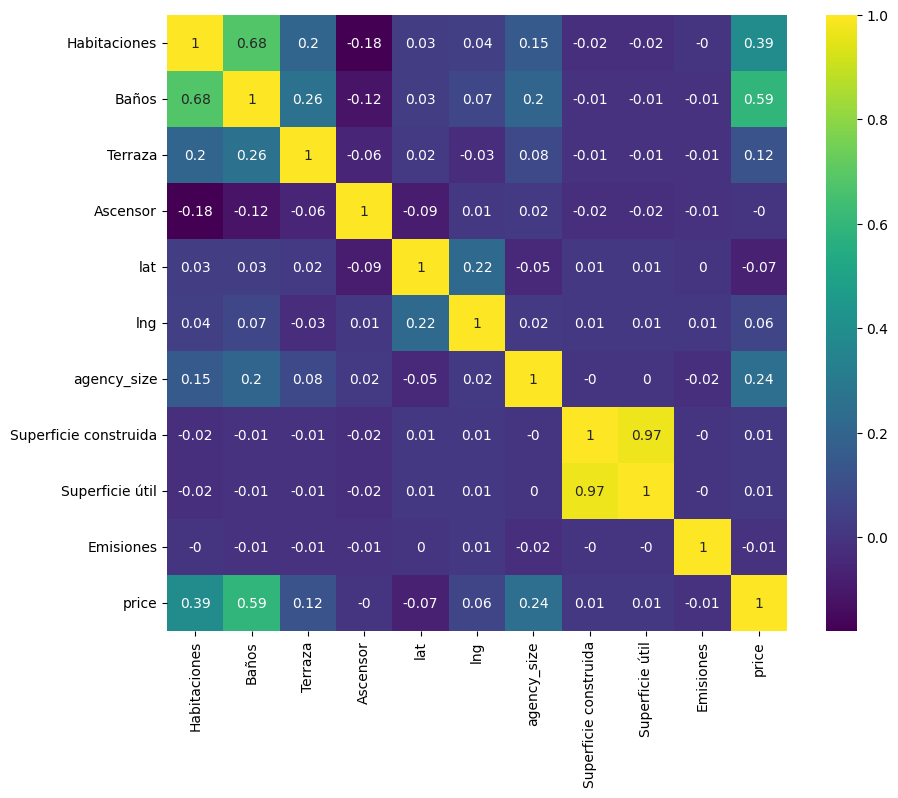

In [168]:
# heatmap de corr
plt.figure(figsize=(10, 8))
sns.heatmap(df_to_eda.corr().round(2), annot=True, cmap='viridis')

In [170]:
df_to_model = df[[
    'Habitaciones', 'Baños', 'Terraza',
    'agency_size', 'price'
]]

In [171]:
X = df_to_model.drop('price', axis=1)
y = df_to_model['price']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [177]:
df_resultados = pd.DataFrame(columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MAPE'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


models = {
    'RLM': LinearRegression(),
    'KNN k = 3': KNeighborsRegressor(n_neighbors=3),
    'KNN k = 5': KNeighborsRegressor(n_neighbors=5),
    'KNN k = 7': KNeighborsRegressor(n_neighbors=7),
    'KNN k = 9': KNeighborsRegressor(n_neighbors=9),
    'DT depth = 5': DecisionTreeRegressor(max_depth=5),
    'DT depth = no': DecisionTreeRegressor(),
    'RF 100': RandomForestRegressor(),
    'RF 150': RandomForestRegressor(n_estimators=150),
    'SVR 1': SVR(C=1),
    'SVR 10': SVR(C=10),
    'SVR 1_000_000': SVR(C=1_000_000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) # (multiplicar mentalmente por 100)

    df_resultados.loc[len(df_resultados)] = [name, r2, mae, rmse, mape]

In [176]:
df_resultados.sort_values('R2', ascending=False)

,Modelo,R2,MAE,RMSE,MAPE
3,KNN k = 7,0.453544,177997.033882,399613.075172,0.460183
2,KNN k = 5,0.440558,182642.380002,404333.398854,0.477722
4,DT depth = 5,0.438411,192512.273333,405108.513015,0.533485
0,RLM,0.385515,216417.303020,423757.849745,0.625065
1,KNN k = 3,0.368901,192688.352202,429448.204671,0.494235
5,DT depth = no,-0.061601,205721.179907,556984.023479,0.510717


Necesitaríamos mejorar los datos para poder mejorar el modelado. Actualmente hay pocas correlaciones con el price.